# 07__motif_coverage
# analyzing how motif coverage correlates with MPRA properties and biotypes; clustering similar motifs

in this notebook, i look at how the coverage metrics (# bp covered and max coverage of motifs; done separately, see methods) look within biotypes. i look at either the motifs alone, the motifs *after* limiting to only those motifs which have been validated by a corresponding chip peak, and non-redundant 8mer motifs from Mariani et al. i also cluster the motifs using MoSBAT (done separately using their webtool) and re-calculate the metrics. finally, i examine the conservation of overlapping motifs using phylop 46-way placental mammal scores.

------

figures in this notebook:
- **Fig 2D and 2F**: cumulative density plots of # bp covered and max motif coverage across biotypes
- **Fig 2E and 2G**: cumulative density plots of # bp covered and max motif coverage within lincRNAs and mRNAs, separated by specificity profiles
- **Fig S9**: heatmap of MoSBAT clustered motifs, and more cumulative density plots (after using the two clustering methods)
- **Fig 2H**: conservation of overlapping motifs via phylop46way scores

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time

from itertools import chain
from decimal import Decimal
from random import shuffle
from scipy import stats
from scipy import signal
from scipy.spatial import distance
from scipy.cluster import hierarchy
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *

%matplotlib inline

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
mosbat_file = "../../misc/02__mosbat/results.from_mosbat.txt"

In [30]:
all_tss_f = "../../data/00__index/0__all_tss/All.TSS.114bp.uniq.new.bed"
cage_expr_f = "../../misc/01__cage/All_TSS_and_enh.CAGE_grouped_exp.tissue_sp.txt"

In [31]:
fimo_cov_f = "../../data/04__coverage/all_fimo_map.all_cov.new.txt"
fimo_chip_cov_f = "../../data/04__coverage/all_fimo_map.chip_intersected.all_cov.new.txt"
fimo_clust_cov_f = "../../data/04__coverage/all_fimo_map.bulyk_clusters.all_cov.new.txt"
fimo_mosbat_cov_f = "../../data/04__coverage/all_fimo_map.mosbat_clusters.all_cov.new.txt"

pool1_fimo_cov_f = "../../data/04__coverage/pool1_fimo_map.all_cov.new.txt"
pool1_fimo_chip_cov_f = "../../data/04__coverage/all_fimo_map.chip_intersectedall_cov.new.txt"

In [6]:
fimo_phylop_f = "../../misc/03__fimo/03__phylop_meta_plot/all_fimo_map.phylop46way.txt"
fimo_chip_phylop_f = "../../misc/03__fimo/03__phylop_meta_plot/all_fimo_map.chip_intersected.phylop46way.txt"
fimo_clust_phylop_f = "../../misc/03__fimo/03__phylop_meta_plot/all_fimo_map.bulyk_clusters.phylop46way.txt"

In [7]:
all_phylop_f = "../../data/00__index/0__all_tss/All.TSS.114bp.uniq.phylop46way.txt"

In [8]:
dnase_f = "../../misc/05__dnase/All.TSS.114bp.uniq.count_DNase_accessible_samples.txt"

note: the reason why some IDs are not in the expression file is these are FANTOM CAT IDs that for some reason are not present in the FANTOM5 robust set. so, we exclude these.

## 1. import data

In [9]:
corr = pd.read_table(mosbat_file, sep="\t")

In [10]:
all_phylop = pd.read_table(all_phylop_f, sep="\t")
all_phylop.columns = ["chr", "start", "end", "unique_id", "score", "strand", "size", "num_data", "min", "max",
                      "mean", "median"]
all_phylop.head()

,chr,start,end,unique_id,score,strand,size,num_data,min,max,mean,median
0,chr10,100027916,100028031,protein_coding__p1@LOXL4__chr10:100027943..100...,0,-,115,115,-3.70,2.09,0.26,0.09
1,chr10,100074495,100074610,Enhancer__chr10:100074404-100074582,0,+,115,115,-2.46,2.73,0.66,0.49
2,chr10,100076068,100076183,Enhancer__chr10:100076038-100076149,0,+,115,115,-3.45,2.18,-0.27,-0.14
3,chr10,100076605,100076720,Enhancer__chr10:100076500-100076699,0,+,115,115,-2.98,2.41,0.18,0.21
4,chr10,100083158,100083273,Enhancer__chr10:100082942-100083374,0,+,115,115,-2.89,2.36,-0.05,-0.03


In [11]:
fimo_phylop = pd.read_table(fimo_phylop_f, sep="\t", header=None)
cols = ["chr", "start", "end", "motif", "n_ov", "tss_dist"]
cols.extend(np.arange(-150, 150, step=1))
fimo_phylop.columns = cols

In [12]:
fimo_chip_phylop = pd.read_table(fimo_chip_phylop_f, sep="\t", header=None)
fimo_chip_phylop.columns = cols

In [13]:
fimo_clust_phylop = pd.read_table(fimo_clust_phylop_f, sep="\t", header=None)
fimo_clust_phylop.columns = cols

In [14]:
dnase = pd.read_table(dnase_f, sep="\t", header=None)
dnase.columns = ["unique_id", "n_accessible"]
dnase["PromType2"] = dnase.unique_id.str.split("__", expand=True)[0]

In [15]:
fimo_cov = pd.read_table(fimo_cov_f, sep="\t")
fimo_chip_cov = pd.read_table(fimo_chip_cov_f, sep="\t")
fimo_clust_cov = pd.read_table(fimo_clust_cov_f, sep="\t")
fimo_mosbat_cov = pd.read_table(fimo_mosbat_cov_f, sep="\t")
fimo_chip_cov.sample(5)

,unique_id,cage_id,n_motifs,n_bp_cov,max_cov,avg_tf_tissue_sp,log_n_motifs,log_bp_cov,log_max_cov,log_avg_tf_tissue_sp
71,Enhancer__chr10:103090701-103091057,chr10:103090701-103091057,2,16,1,NaN,1.098612,2.833213,0.693147,NaN
220,Enhancer__chr10:112290201-112290297,chr10:112290201-112290297,10,40,4,0.433334,2.397895,3.713572,1.609438,0.360003
26786,Enhancer__chr3:196347011-196347384,chr3:196347011-196347384,10,47,5,0.360128,2.397895,3.871201,1.791759,0.307579
20049,"div_pc__p4@CDC25B__chr20:3767547..3767623,+","chr20:3767547..3767623,+",7,56,3,NaN,2.079442,4.043051,1.386294,NaN
14545,protein_coding__p1@RASD1__chr17:17399701..1739...,"chr17:17399701..17399716,-",15,86,6,NaN,2.772589,4.465908,1.945910,NaN


In [16]:
print(len(fimo_cov))
print(len(fimo_chip_cov))
print(len(fimo_clust_cov))
print(len(fimo_mosbat_cov))

56562
40360
35093
56514


In [18]:
fimo_cov["PromType2"] = fimo_cov["unique_id"].str.split("__", expand=True)[0]
fimo_chip_cov["PromType2"] = fimo_chip_cov["unique_id"].str.split("__", expand=True)[0]
fimo_clust_cov["PromType2"] = fimo_clust_cov["unique_id"].str.split("__", expand=True)[0]
fimo_mosbat_cov["PromType2"] = fimo_mosbat_cov["unique_id"].str.split("__", expand=True)[0]
fimo_cov.sample(5)

,unique_id,cage_id,n_motifs,n_bp_cov,max_cov,avg_tf_tissue_sp,log_n_motifs,log_bp_cov,log_max_cov,log_avg_tf_tissue_sp,PromType2
24193,protein_coding__p5@CCDC159__chr19:11455369..11...,"chr19:11455369..11455389,+",23,74,12,NaN,3.178054,4.317488,2.564949,NaN,protein_coding
31792,"intergenic__NA__chr22:20192527..20192568,-","chr22:20192527..20192568,-",14,44,6,NaN,2.708050,3.806662,1.945910,NaN,intergenic
13610,"protein_coding__NA__chr13:88324795..88324832,+","chr13:88324795..88324832,+",19,103,7,NaN,2.995732,4.644391,2.079442,NaN,protein_coding
32620,Enhancer__chr2:235457689-235457991,chr2:235457689-235457991,15,71,7,0.347811,2.772589,4.276666,2.079442,0.298482,Enhancer
46530,Enhancer__chr6:4355650-4355845,chr6:4355650-4355845,13,57,7,0.345134,2.639057,4.060443,2.079442,0.296493,Enhancer


In [19]:
# filter to those that have at least 1 motif so distributions are not 0-skewed
fimo_cov = fimo_cov[fimo_cov["n_motifs"] > 0]
print(len(fimo_cov))

fimo_chip_cov = fimo_chip_cov[fimo_chip_cov["n_motifs"] > 0]
print(len(fimo_chip_cov))

fimo_clust_cov = fimo_clust_cov[fimo_clust_cov["n_motifs"] > 0]
print(len(fimo_clust_cov))

fimo_mosbat_cov = fimo_mosbat_cov[fimo_mosbat_cov["n_motifs"] > 0]
print(len(fimo_mosbat_cov))

56562
40358
35077
56514


In [20]:
cage_expr = pd.read_table(cage_expr_f, sep="\t")
cage_expr.head()

,cage_id,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
0,"chr10:100013403..100013414,-",0.023403,0.993829,0.666667,38,tissue-specific
1,"chr10:100027943..100027958,-",5.375834,0.968756,0.666667,346,moderate
2,"chr10:100076685..100076699,+",0.012479,0.984646,NaN,34,tissue-specific
3,"chr10:100150910..100150935,-",0.155925,0.991970,NaN,80,moderate
4,"chr10:100150951..100150962,-",0.038083,0.981522,NaN,49,tissue-specific


In [21]:
# inner merging with this file ensures that we are only looking at robust TSSs and robust enhancers
fimo_cov = fimo_cov.merge(cage_expr, on="cage_id", how="left")
fimo_cov.head()

,unique_id,cage_id,n_motifs,n_bp_cov,max_cov,avg_tf_tissue_sp,log_n_motifs,log_bp_cov,log_max_cov,log_avg_tf_tissue_sp,PromType2,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
0,protein_coding__p1@LOXL4__chr10:100027943..100...,"chr10:100027943..100027958,-",19,66,7,NaN,2.995732,4.204693,2.079442,NaN,protein_coding,5.375834,0.968756,0.666667,346.0,moderate
1,Enhancer__chr10:100074404-100074582,chr10:100074404-100074582,26,91,9,0.498479,3.295837,4.521789,2.302585,0.404451,Enhancer,0.015866,0.993289,0.666667,31.0,tissue-specific
2,Enhancer__chr10:100076038-100076149,chr10:100076038-100076149,25,78,8,0.338257,3.258097,4.369448,2.197225,0.291368,Enhancer,0.022990,0.995153,NaN,24.0,tissue-specific
3,Enhancer__chr10:100076500-100076699,chr10:100076500-100076699,21,89,8,0.394609,3.091042,4.499810,2.197225,0.332614,Enhancer,0.029745,0.981128,NaN,67.0,moderate
4,Enhancer__chr10:100082942-100083374,chr10:100082942-100083374,36,93,13,0.375421,3.610918,4.543295,2.639057,0.318760,Enhancer,0.023984,0.986789,0.666667,47.0,tissue-specific


In [22]:
fimo_chip_cov = fimo_chip_cov.merge(cage_expr, on="cage_id", how="left")
fimo_chip_cov.sample(5)

,unique_id,cage_id,n_motifs,n_bp_cov,max_cov,avg_tf_tissue_sp,log_n_motifs,log_bp_cov,log_max_cov,log_avg_tf_tissue_sp,PromType2,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
18934,Enhancer__chr19:50990086-50990332,chr19:50990086-50990332,5,60,2,0.453740,1.791759,4.110874,1.098612,0.374140,Enhancer,0.097385,0.987170,0.478980,105.0,moderate
29570,Enhancer__chr5:1315765-1316275,chr5:1315765-1316275,6,33,5,0.353899,1.945910,3.526361,1.791759,0.302989,Enhancer,0.067332,0.986268,0.666667,73.0,moderate
124,protein_coding__p1@INA__chr10:105036887..10503...,"chr10:105036887..105036903,+",4,45,1,NaN,1.609438,3.828641,0.693147,NaN,protein_coding,16.851825,0.965769,0.515530,349.0,moderate
28085,Enhancer__chr4:141174275-141174653,chr4:141174275-141174653,7,53,2,0.408936,2.079442,3.988984,1.098612,0.342835,Enhancer,0.197541,0.958352,NaN,291.0,moderate
35370,protein_coding__p2@IKZF1__chr7:50343634..50343...,"chr7:50343634..50343717,+",5,58,2,NaN,1.791759,4.077537,1.098612,NaN,protein_coding,4.694517,0.943920,0.665945,269.0,moderate


In [23]:
fimo_clust_cov = fimo_clust_cov.merge(cage_expr, on="cage_id", how="left")
fimo_clust_cov.head()

,unique_id,cage_id,n_motifs,n_bp_cov,max_cov,log_n_motifs,log_bp_cov,log_max_cov,PromType2,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
0,protein_coding__p1@LOXL4__chr10:100027943..100...,"chr10:100027943..100027958,-",10,67,3,2.397895,4.219508,1.386294,protein_coding,5.375834,0.968756,0.666667,346.0,moderate
1,Enhancer__chr10:100076038-100076149,chr10:100076038-100076149,1,13,1,0.693147,2.639057,0.693147,Enhancer,0.022990,0.995153,NaN,24.0,tissue-specific
2,protein_coding__p1@PYROXD2__chr10:100174900..1...,"chr10:100174900..100174956,-",4,39,1,1.609438,3.688879,0.693147,protein_coding,5.764484,0.872210,0.547032,508.0,ubiquitous
3,protein_coding__p1@HPS1__chr10:100206642..1002...,"chr10:100206642..100206717,-",11,63,4,2.484907,4.158883,1.609438,protein_coding,30.877938,0.777160,0.192167,546.0,ubiquitous
4,protein_coding__p1@HPSE2__chr10:100995440..100...,"chr10:100995440..100995474,-",12,49,5,2.564949,3.912023,1.791759,protein_coding,0.639976,0.966872,NaN,142.0,moderate


In [24]:
fimo_mosbat_cov = fimo_mosbat_cov.merge(cage_expr, on="cage_id", how="left")
fimo_mosbat_cov.head()

,unique_id,cage_id,n_motifs,n_bp_cov,max_cov,log_n_motifs,log_bp_cov,log_max_cov,PromType2,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
0,protein_coding__p1@LOXL4__chr10:100027943..100...,"chr10:100027943..100027958,-",4,66,5,1.609438,4.204693,1.791759,protein_coding,5.375834,0.968756,0.666667,346.0,moderate
1,Enhancer__chr10:100074404-100074582,chr10:100074404-100074582,4,71,5,1.609438,4.276666,1.791759,Enhancer,0.015866,0.993289,0.666667,31.0,tissue-specific
2,Enhancer__chr10:100076038-100076149,chr10:100076038-100076149,2,74,11,1.098612,4.317488,2.484907,Enhancer,0.022990,0.995153,NaN,24.0,tissue-specific
3,Enhancer__chr10:100076500-100076699,chr10:100076500-100076699,4,87,8,1.609438,4.477337,2.197225,Enhancer,0.029745,0.981128,NaN,67.0,moderate
4,Enhancer__chr10:100082942-100083374,chr10:100082942-100083374,3,90,12,1.386294,4.510860,2.564949,Enhancer,0.023984,0.986789,0.666667,47.0,tissue-specific


In [25]:
chip_cov_exp = fimo_chip_cov[~pd.isnull(fimo_chip_cov["av_exp"])]
motif_cov_exp = fimo_cov[~pd.isnull(fimo_cov["av_exp"])]
cluster_cov_exp = fimo_clust_cov[~pd.isnull(fimo_clust_cov["av_exp"])]
mosbat_cov_exp = fimo_mosbat_cov[~pd.isnull(fimo_mosbat_cov["av_exp"])]

In [26]:
motif_cov_exp.PromType2.value_counts()

Enhancer          17866
protein_coding    11272
div_pc             3455
intergenic         1423
div_lnc             782
antisense           622
Name: PromType2, dtype: int64

In [27]:
chip_cov_exp.PromType2.value_counts()

Enhancer          13539
protein_coding     9869
div_pc             3359
intergenic          992
div_lnc             742
antisense           447
Name: PromType2, dtype: int64

In [28]:
cluster_cov_exp.PromType2.value_counts()

protein_coding    10889
Enhancer           5457
div_pc             3390
intergenic         1302
div_lnc             768
antisense           586
Name: PromType2, dtype: int64

In [32]:
all_tss = pd.read_table(all_tss_f, sep="\t", header=None)
all_tss.columns = ["chr", "start", "end", "name", "score", "strand"]
all_tss["PromType2"] = all_tss["name"].str.split("__", expand=True)[0]
all_tss.PromType2.value_counts()

Enhancer          29807
protein_coding    14332
intergenic         4280
div_pc             4235
antisense          2247
div_lnc            1713
Name: PromType2, dtype: int64

## 2. plot # bp covered & max cov across biotypes

### all motifs

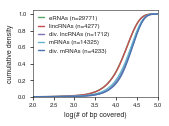

In [33]:
enh_vals = fimo_cov[fimo_cov["PromType2"] == "Enhancer"]["log_bp_cov"]
linc_vals = fimo_cov[fimo_cov["PromType2"] == "intergenic"]["log_bp_cov"]
dlnc_vals = fimo_cov[fimo_cov["PromType2"] == "div_lnc"]["log_bp_cov"]
pc_vals = fimo_cov[fimo_cov["PromType2"] == "protein_coding"]["log_bp_cov"]
dpc_vals = fimo_cov[fimo_cov["PromType2"] == "div_pc"]["log_bp_cov"]

fig = plt.figure(figsize=(2.25, 1.6))
ax = sns.kdeplot(data=enh_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs (n=%s)" % len(enh_vals))
sns.kdeplot(data=linc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs (n=%s)" % len(linc_vals), ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs (n=%s)" % len(dlnc_vals), ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs (n=%s)" % len(pc_vals), ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs (n=%s)" % len(dpc_vals), ax=ax)
ax.set_xlabel("log(# of bp covered)")
ax.set_ylabel("cumulative density")
ax.set_xlim((2, 5))
ax.set_ylim((0, 1.05))
plt.legend(handlelength=1)

i: 0, promtype: Enhancer, name: eRNAs
ub/ts pval: 4.91980164211e-07
ub/dy pval: 0.00173371418102
ts/dy pval: 0.00263441209912
i: 1, promtype: intergenic, name: lincRNAs
ub/ts pval: 7.86314682475e-08
ub/dy pval: 5.65098867961e-06
ts/dy pval: 0.151227887342
i: 2, promtype: protein_coding, name: mRNAs
ub/ts pval: 3.07849140321e-77
ub/dy pval: 3.92402717903e-39
ts/dy pval: 0.0815376244426


(0, 1.05)

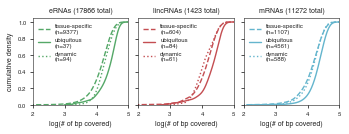

In [34]:
# for each group, split into tissue-sp v dynamic v ubiquitous
idxs = list(range(0, 5))
promtypes = ["Enhancer", "intergenic", "protein_coding"]
names = ["eRNAs", "lincRNAs", "mRNAs"]
df = motif_cov_exp
col = "log_bp_cov"
xlabel = "log(# of bp covered)"
xlim = (2, 5)

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(5.5, 1.6))

for i, promtype, name in zip(idxs, promtypes, names):
    print("i: %s, promtype: %s, name: %s" % (i, promtype, name))
    ax = axarr[i]
    
    promtype_vals = df[df["PromType2"] == promtype]
    ts_vals = promtype_vals[promtype_vals["tss_type"] == "tissue-specific"][col]
    ub_vals = promtype_vals[promtype_vals["tss_type"] == "ubiquitous"][col]
    dy_vals = promtype_vals[promtype_vals["tss_type"] == "dynamic"][col]
    
    ub_ts_u, ub_ts_pval = stats.mannwhitneyu(ub_vals, ts_vals, alternative="two-sided", use_continuity=False)
    print("ub/ts pval: %s" % ub_ts_pval)
    
    ub_dy_u, ub_dy_pval = stats.mannwhitneyu(ub_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ub/dy pval: %s" % ub_dy_pval)
    
    ts_dy_u, ts_dy_pval = stats.mannwhitneyu(ts_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ts/dy pval: %s" % ts_dy_pval)
    
    sns.kdeplot(data=ts_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dashed",
                label="tissue-specific\n(n=%s)" % len(ts_vals), ax=ax)
    sns.kdeplot(data=ub_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="solid",
                label="ubiquitous\n(n=%s)" % len(ub_vals), ax=ax)
    sns.kdeplot(data=dy_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dotted",
                label="dynamic\n(n=%s)" % len(dy_vals), ax=ax)
    
    ax.set_title("%s (%s total)" % (name, len(promtype_vals)))
    ax.set_xlabel(xlabel)
    ax.legend(loc="upper left", handlelength=2)
    ax.set_xlim(xlim)
    
    if i == 0:
        ax.set_ylabel("cumulative density")

plt.subplots_adjust(wspace=0.1)
plt.ylim((0, 1.05))

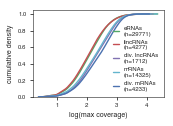

In [35]:
enh_vals = fimo_cov[fimo_cov["PromType2"] == "Enhancer"]["log_max_cov"]
linc_vals = fimo_cov[fimo_cov["PromType2"] == "intergenic"]["log_max_cov"]
dlnc_vals = fimo_cov[fimo_cov["PromType2"] == "div_lnc"]["log_max_cov"]
pc_vals = fimo_cov[fimo_cov["PromType2"] == "protein_coding"]["log_max_cov"]
dpc_vals = fimo_cov[fimo_cov["PromType2"] == "div_pc"]["log_max_cov"]

fig = plt.figure(figsize=(2.35, 1.6))
ax = sns.kdeplot(data=enh_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs\n(n=%s)" % len(enh_vals))
sns.kdeplot(data=linc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs\n(n=%s)" % len(linc_vals), ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs\n(n=%s)" % len(dlnc_vals), ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs\n(n=%s)" % len(pc_vals), ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs\n(n=%s)" % len(dpc_vals), ax=ax)
ax.set_xlabel("log(max coverage)")
ax.set_ylabel("cumulative density")
ax.set_ylim((0, 1.05))
ax.legend(loc="bottom right", handlelength=1)
#fig.savefig("max_cov.all_biotypes.for_poster.pdf", dpi="figure", bbox_inches="tight")

i: 0, promtype: Enhancer, name: eRNAs
ub/ts pval: 4.68343437712e-07
ub/dy pval: 6.32303148491e-05
ts/dy pval: 0.854221458313
i: 1, promtype: intergenic, name: lincRNAs
ub/ts pval: 3.5364473839e-08
ub/dy pval: 0.000805549021588
ts/dy pval: 0.788902589974
i: 2, promtype: protein_coding, name: mRNAs
ub/ts pval: 5.90482404219e-94
ub/dy pval: 2.01246805284e-52
ts/dy pval: 0.530782789062


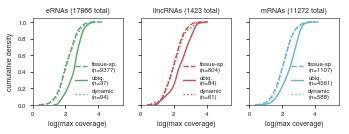

In [36]:
# for each group, split into tissue-sp v dynamic v ubiquitous
idxs = list(range(0, 5))
promtypes = ["Enhancer", "intergenic", "protein_coding"]
names = ["eRNAs", "lincRNAs", "mRNAs"]
df = motif_cov_exp
col = "log_max_cov"
xlabel = "log(max coverage)"
xlim = (0, 5.5)

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(5.5, 1.6))

for i, promtype, name in zip(idxs, promtypes, names):
    print("i: %s, promtype: %s, name: %s" % (i, promtype, name))
    ax = axarr[i]
    
    promtype_vals = df[df["PromType2"] == promtype]
    ts_vals = promtype_vals[promtype_vals["tss_type"] == "tissue-specific"][col]
    ub_vals = promtype_vals[promtype_vals["tss_type"] == "ubiquitous"][col]
    dy_vals = promtype_vals[promtype_vals["tss_type"] == "dynamic"][col]
    
    ub_ts_u, ub_ts_pval = stats.mannwhitneyu(ub_vals, ts_vals, alternative="two-sided", use_continuity=False)
    print("ub/ts pval: %s" % ub_ts_pval)
    
    ub_dy_u, ub_dy_pval = stats.mannwhitneyu(ub_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ub/dy pval: %s" % ub_dy_pval)
    
    ts_dy_u, ts_dy_pval = stats.mannwhitneyu(ts_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ts/dy pval: %s" % ts_dy_pval)
    
    sns.kdeplot(data=ts_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dashed",
                label="tissue-sp.\n(n=%s)" % len(ts_vals), ax=ax)
    sns.kdeplot(data=ub_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="solid",
                label="ubiq.\n(n=%s)" % len(ub_vals), ax=ax)
    sns.kdeplot(data=dy_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dotted",
                label="dynamic\n(n=%s)" % len(dy_vals), ax=ax)
    
    ax.set_title("%s (%s total)" % (name, len(promtype_vals)))
    ax.set_xlabel(xlabel)
    ax.legend(loc="bottom right", handlelength=2)
    ax.set_xlim(xlim)
    ax.set_ylim((0, 1.05))
    
    if i == 0:
        ax.set_ylabel("cumulative density")

### ChIP-validated motifs

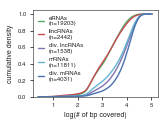

In [37]:
enh_vals = fimo_chip_cov[fimo_chip_cov["PromType2"] == "Enhancer"]["log_bp_cov"]
linc_vals = fimo_chip_cov[fimo_chip_cov["PromType2"] == "intergenic"]["log_bp_cov"]
dlnc_vals = fimo_chip_cov[fimo_chip_cov["PromType2"] == "div_lnc"]["log_bp_cov"]
pc_vals = fimo_chip_cov[fimo_chip_cov["PromType2"] == "protein_coding"]["log_bp_cov"]
dpc_vals = fimo_chip_cov[fimo_chip_cov["PromType2"] == "div_pc"]["log_bp_cov"]

fig = plt.figure(figsize=(2.25, 1.6))
ax = sns.kdeplot(data=enh_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs\n(n=%s)" % len(enh_vals))
sns.kdeplot(data=linc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs\n(n=%s)" % len(linc_vals), ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs\n(n=%s)" % len(dlnc_vals), ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs\n(n=%s)" % len(pc_vals), ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs\n(n=%s)" % len(dpc_vals), ax=ax)
ax.set_xlabel("log(# of bp covered)")
ax.set_ylabel("cumulative density")
ax.set_ylim((0, 1.05))
plt.legend(handlelength=1)
fig.savefig("Fig_2D.pdf", bbox_inches="tight", dpi="figure")

i: 0, promtype: Enhancer, name: eRNAs
ub/ts pval: 5.50890959758e-19
ub/dy pval: 1.24059535023e-11
ts/dy pval: 0.484897802464
i: 1, promtype: intergenic, name: lincRNAs
ub/ts pval: 1.54241589184e-27
ub/dy pval: 9.67484185432e-10
ts/dy pval: 0.932905269657
i: 2, promtype: protein_coding, name: mRNAs
ub/ts pval: 4.38719007414e-254
ub/dy pval: 7.58145769949e-152
ts/dy pval: 0.0565732787496


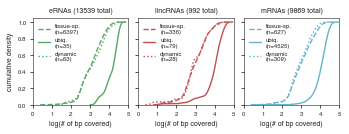

In [38]:
# for each group, split into tissue-sp v dynamic v ubiquitous
idxs = list(range(0, 5))
promtypes = ["Enhancer", "intergenic", "protein_coding"]
names = ["eRNAs", "lincRNAs", "mRNAs"]
df = chip_cov_exp
col = "log_bp_cov"
xlabel = "log(# of bp covered)"
xlim = (0, 5)

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(5.5, 1.6))

for i, promtype, name in zip(idxs, promtypes, names):
    print("i: %s, promtype: %s, name: %s" % (i, promtype, name))
    ax = axarr[i]
    
    promtype_vals = df[df["PromType2"] == promtype]
    ts_vals = promtype_vals[promtype_vals["tss_type"] == "tissue-specific"][col]
    ub_vals = promtype_vals[promtype_vals["tss_type"] == "ubiquitous"][col]
    dy_vals = promtype_vals[promtype_vals["tss_type"] == "dynamic"][col]
    
    ub_ts_u, ub_ts_pval = stats.mannwhitneyu(ub_vals, ts_vals, alternative="two-sided", use_continuity=False)
    print("ub/ts pval: %s" % ub_ts_pval)
    
    ub_dy_u, ub_dy_pval = stats.mannwhitneyu(ub_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ub/dy pval: %s" % ub_dy_pval)
    
    ts_dy_u, ts_dy_pval = stats.mannwhitneyu(ts_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ts/dy pval: %s" % ts_dy_pval)
    
    sns.kdeplot(data=ts_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dashed",
                label="tissue-sp.\n(n=%s)" % len(ts_vals), ax=ax)
    sns.kdeplot(data=ub_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="solid",
                label="ubiq.\n(n=%s)" % len(ub_vals), ax=ax)
    sns.kdeplot(data=dy_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dotted",
                label="dynamic\n(n=%s)" % len(dy_vals), ax=ax)
    
    ax.set_title("%s (%s total)" % (name, len(promtype_vals)))
    ax.set_xlabel(xlabel)
    ax.legend(loc="bottom right", handlelength=2)
    ax.set_xlim(xlim)
    ax.set_ylim((0, 1.05))
    
    if i == 0:
        ax.set_ylabel("cumulative density")
        
plt.subplots_adjust(wspace=0.1)
f.savefig("Fig_2E.pdf", bbox_inches="tight", dpi="figure")

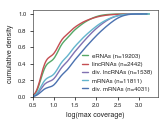

In [41]:
enh_vals = fimo_chip_cov[fimo_chip_cov["PromType2"] == "Enhancer"]["log_max_cov"]
linc_vals = fimo_chip_cov[fimo_chip_cov["PromType2"] == "intergenic"]["log_max_cov"]
dlnc_vals = fimo_chip_cov[fimo_chip_cov["PromType2"] == "div_lnc"]["log_max_cov"]
pc_vals = fimo_chip_cov[fimo_chip_cov["PromType2"] == "protein_coding"]["log_max_cov"]
dpc_vals = fimo_chip_cov[fimo_chip_cov["PromType2"] == "div_pc"]["log_max_cov"]

fig = plt.figure(figsize=(2.25, 1.6))
ax = sns.kdeplot(data=enh_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs (n=%s)" % len(enh_vals))
sns.kdeplot(data=linc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs (n=%s)" % len(linc_vals), ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs (n=%s)" % len(dlnc_vals), ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs (n=%s)" % len(pc_vals), ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs (n=%s)" % len(dpc_vals), ax=ax)
ax.set_xlabel("log(max coverage)")
ax.set_ylabel("cumulative density")
ax.set_ylim((0, 1.05))
ax.set_xlim((0.5, 3.45))
plt.legend(handlelength=1)

fig.savefig("Fig_2F.pdf", bbox_inches="tight", dpi="figure")

i: 0, promtype: Enhancer, name: eRNAs
ub/ts pval: 1.86333912097e-18
ub/dy pval: 1.13038718841e-11
ts/dy pval: 0.572371468134
i: 1, promtype: intergenic, name: lincRNAs
ub/ts pval: 3.10213385417e-27
ub/dy pval: 2.50566071337e-07
ts/dy pval: 0.271475364258
i: 2, promtype: protein_coding, name: mRNAs
ub/ts pval: 2.44278127622e-232
ub/dy pval: 1.14275738066e-124
ts/dy pval: 0.968108460128


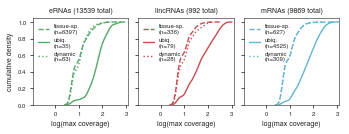

In [46]:
# for each group, split into tissue-sp v dynamic v ubiquitous
idxs = list(range(0, 5))
promtypes = ["Enhancer", "intergenic", "protein_coding"]
names = ["eRNAs", "lincRNAs", "mRNAs"]
df = chip_cov_exp
col = "log_max_cov"
xlabel = "log(max coverage)"
xlim = (-0.95, 3.1)

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(5.5, 1.6))

for i, promtype, name in zip(idxs, promtypes, names):
    print("i: %s, promtype: %s, name: %s" % (i, promtype, name))
    ax = axarr[i]
    
    promtype_vals = df[df["PromType2"] == promtype]
    ts_vals = promtype_vals[promtype_vals["tss_type"] == "tissue-specific"][col]
    ub_vals = promtype_vals[promtype_vals["tss_type"] == "ubiquitous"][col]
    dy_vals = promtype_vals[promtype_vals["tss_type"] == "dynamic"][col]
    
    ub_ts_u, ub_ts_pval = stats.mannwhitneyu(ub_vals, ts_vals, alternative="two-sided", use_continuity=False)
    print("ub/ts pval: %s" % ub_ts_pval)
    
    ub_dy_u, ub_dy_pval = stats.mannwhitneyu(ub_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ub/dy pval: %s" % ub_dy_pval)
    
    ts_dy_u, ts_dy_pval = stats.mannwhitneyu(ts_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ts/dy pval: %s" % ts_dy_pval)
    
    sns.kdeplot(data=ts_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dashed",
                label="tissue-sp.\n(n=%s)" % len(ts_vals), ax=ax)
    sns.kdeplot(data=ub_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="solid",
                label="ubiq.\n(n=%s)" % len(ub_vals), ax=ax)
    sns.kdeplot(data=dy_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dotted",
                label="dynamic\n(n=%s)" % len(dy_vals), ax=ax)
    
    ax.set_title("%s (%s total)" % (name, len(promtype_vals)))
    ax.set_xlabel(xlabel)
    ax.legend(loc="upper left", handlelength=1.8)
    ax.set_ylim((0, 1.05))
    ax.set_xlim(xlim)
    
    if i == 0:
        ax.set_ylabel("cumulative density")
plt.subplots_adjust(wspace=0.1)
f.savefig("Fig_2G.pdf", bbox_inches="tight", dpi="figure")

### clustered motifs

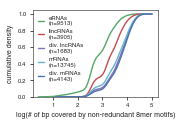

In [47]:
enh_vals = fimo_clust_cov[fimo_clust_cov["PromType2"] == "Enhancer"]["log_bp_cov"]
linc_vals = fimo_clust_cov[fimo_clust_cov["PromType2"] == "intergenic"]["log_bp_cov"]
dlnc_vals = fimo_clust_cov[fimo_clust_cov["PromType2"] == "div_lnc"]["log_bp_cov"]
pc_vals = fimo_clust_cov[fimo_clust_cov["PromType2"] == "protein_coding"]["log_bp_cov"]
dpc_vals = fimo_clust_cov[fimo_clust_cov["PromType2"] == "div_pc"]["log_bp_cov"]

fig = plt.figure(figsize=(2.25, 1.6))
ax = sns.kdeplot(data=enh_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs\n(n=%s)" % len(enh_vals))
sns.kdeplot(data=linc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs\n(n=%s)" % len(linc_vals), ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs\n(n=%s)" % len(dlnc_vals), ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs\n(n=%s)" % len(pc_vals), ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs\n(n=%s)" % len(dpc_vals), ax=ax)
ax.set_xlabel("log(# of bp covered by non-redundant 8mer motifs)")
ax.set_ylabel("cumulative density")
ax.set_ylim((0, 1.05))
plt.legend(handlelength=1)
fig.savefig("Fig_S9C_1.pdf", bbox_inches="tight", dpi="figure")

i: 0, promtype: Enhancer, name: eRNAs
ub/ts pval: 0.210409326737
ub/dy pval: 0.635933482817
ts/dy pval: 0.374418946433
i: 1, promtype: intergenic, name: lincRNAs
ub/ts pval: 1.31791535328e-14
ub/dy pval: 2.9999298934e-07
ts/dy pval: 0.604638967569
i: 2, promtype: protein_coding, name: mRNAs
ub/ts pval: 8.60653194177e-166
ub/dy pval: 5.91767514581e-99
ts/dy pval: 0.388968492042


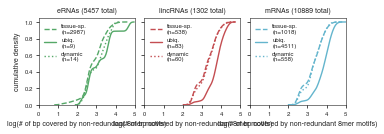

In [48]:
# for each group, split into tissue-sp v dynamic v ubiquitous
idxs = list(range(0, 5))
promtypes = ["Enhancer", "intergenic", "protein_coding"]
names = ["eRNAs", "lincRNAs", "mRNAs"]
df = cluster_cov_exp
col = "log_bp_cov"
xlabel = "log(# of bp covered by non-redundant 8mer motifs)"
xlim = (0, 5)

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(5.5, 1.6))

for i, promtype, name in zip(idxs, promtypes, names):
    print("i: %s, promtype: %s, name: %s" % (i, promtype, name))
    ax = axarr[i]
    
    promtype_vals = df[df["PromType2"] == promtype]
    ts_vals = promtype_vals[promtype_vals["tss_type"] == "tissue-specific"][col]
    ub_vals = promtype_vals[promtype_vals["tss_type"] == "ubiquitous"][col]
    dy_vals = promtype_vals[promtype_vals["tss_type"] == "dynamic"][col]
    
    ub_ts_u, ub_ts_pval = stats.mannwhitneyu(ub_vals, ts_vals, alternative="two-sided", use_continuity=False)
    print("ub/ts pval: %s" % ub_ts_pval)
    
    ub_dy_u, ub_dy_pval = stats.mannwhitneyu(ub_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ub/dy pval: %s" % ub_dy_pval)
    
    ts_dy_u, ts_dy_pval = stats.mannwhitneyu(ts_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ts/dy pval: %s" % ts_dy_pval)
    
    sns.kdeplot(data=ts_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dashed",
                label="tissue-sp.\n(n=%s)" % len(ts_vals), ax=ax)
    sns.kdeplot(data=ub_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="solid",
                label="ubiq.\n(n=%s)" % len(ub_vals), ax=ax)
    sns.kdeplot(data=dy_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dotted",
                label="dynamic\n(n=%s)" % len(dy_vals), ax=ax)
    
    ax.set_title("%s (%s total)" % (name, len(promtype_vals)))
    ax.set_xlabel(xlabel)
    ax.legend(loc="bottom right", handlelength=2)
    ax.set_xlim(xlim)
    ax.set_ylim((0, 1.05))
    
    if i == 0:
        ax.set_ylabel("cumulative density")
plt.subplots_adjust(wspace=0.1)

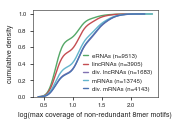

In [50]:
enh_vals = fimo_clust_cov[fimo_clust_cov["PromType2"] == "Enhancer"]["log_max_cov"]
linc_vals = fimo_clust_cov[fimo_clust_cov["PromType2"] == "intergenic"]["log_max_cov"]
dlnc_vals = fimo_clust_cov[fimo_clust_cov["PromType2"] == "div_lnc"]["log_max_cov"]
pc_vals = fimo_clust_cov[fimo_clust_cov["PromType2"] == "protein_coding"]["log_max_cov"]
dpc_vals = fimo_clust_cov[fimo_clust_cov["PromType2"] == "div_pc"]["log_max_cov"]

fig = plt.figure(figsize=(2.25, 1.6))
ax = sns.kdeplot(data=enh_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs (n=%s)" % len(enh_vals))
sns.kdeplot(data=linc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs (n=%s)" % len(linc_vals), ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs (n=%s)" % len(dlnc_vals), ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs (n=%s)" % len(pc_vals), ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs (n=%s)" % len(dpc_vals), ax=ax)
ax.set_xlabel("log(max coverage of non-redundant 8mer motifs)")
ax.set_ylabel("cumulative density")
ax.set_ylim((0, 1.05))
plt.legend(handlelength=0.8)
fig.savefig("Fig_S9C_2.pdf", bbox_inches="tight", dpi="figure")

i: 0, promtype: Enhancer, name: eRNAs
ub/ts pval: 0.0156136374621
ub/dy pval: 0.172366647173
ts/dy pval: 0.486219965444
i: 1, promtype: intergenic, name: lincRNAs
ub/ts pval: 8.49711900137e-12
ub/dy pval: 0.00122740836541
ts/dy pval: 0.0944766789974
i: 2, promtype: protein_coding, name: mRNAs
ub/ts pval: 1.71260627395e-96
ub/dy pval: 5.32310613563e-59
ts/dy pval: 0.729578282812


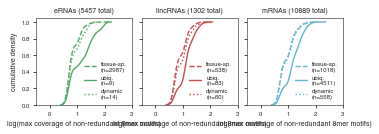

In [51]:
# for each group, split into tissue-sp v dynamic v ubiquitous
idxs = list(range(0, 5))
promtypes = ["Enhancer", "intergenic", "protein_coding"]
names = ["eRNAs", "lincRNAs", "mRNAs"]
df = cluster_cov_exp
col = "log_max_cov"
xlabel = "log(max coverage of non-redundant 8mer motifs)"
xlim = (-0.5, 3)

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(5.5, 1.6))

for i, promtype, name in zip(idxs, promtypes, names):
    print("i: %s, promtype: %s, name: %s" % (i, promtype, name))
    ax = axarr[i]
    
    promtype_vals = df[df["PromType2"] == promtype]
    ts_vals = promtype_vals[promtype_vals["tss_type"] == "tissue-specific"][col]
    ub_vals = promtype_vals[promtype_vals["tss_type"] == "ubiquitous"][col]
    dy_vals = promtype_vals[promtype_vals["tss_type"] == "dynamic"][col]
    
    ub_ts_u, ub_ts_pval = stats.mannwhitneyu(ub_vals, ts_vals, alternative="two-sided", use_continuity=False)
    print("ub/ts pval: %s" % ub_ts_pval)
    
    ub_dy_u, ub_dy_pval = stats.mannwhitneyu(ub_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ub/dy pval: %s" % ub_dy_pval)
    
    ts_dy_u, ts_dy_pval = stats.mannwhitneyu(ts_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ts/dy pval: %s" % ts_dy_pval)
    
    sns.kdeplot(data=ts_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dashed",
                label="tissue-sp.\n(n=%s)" % len(ts_vals), ax=ax)
    sns.kdeplot(data=ub_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="solid",
                label="ubiq.\n(n=%s)" % len(ub_vals), ax=ax)
    sns.kdeplot(data=dy_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dotted",
                label="dynamic\n(n=%s)" % len(dy_vals), ax=ax)
    
    ax.set_title("%s (%s total)" % (name, len(promtype_vals)))
    ax.set_xlabel(xlabel)
    ax.legend(loc="bottom right", handlelength=2)
    ax.set_xlim(xlim)
    ax.set_ylim((0,1.05))
    
    if i == 0:
        ax.set_ylabel("cumulative density")
plt.subplots_adjust(wspace=0.1)

## 2. cluster the motifs using MoSBAT output

In [52]:
corr.set_index(corr["Motif"], inplace=True)
corr.drop("Motif", axis=1, inplace=True)
corr.head()

,RUNX1,TFAP2A,Arnt,Ahr..Arnt,Ar,T,PAX5,NR2F1,CREB1,Ddit3..Cebpa,...,HOXC12,HOXC13,HOXD11,HOXD13,Hoxd8,Hoxa11,Hoxd3,Hoxd9,ISL2,Hes1
Motif,,,,,,,,,,,,,,,,,,,,,
RUNX1,1.000000,0.053362,-0.045079,0.084369,-0.044827,-0.011180,0.009678,0.023699,0.031270,-0.042494,...,-0.046124,-0.054724,-0.089790,-0.021027,-0.038859,-0.082215,0.014631,-0.013418,0.029031,-0.012669
TFAP2A,0.053362,1.000000,0.060590,0.040435,0.008935,-0.033231,0.083051,0.072317,0.036212,0.012966,...,-0.142886,-0.121405,-0.172917,-0.117810,-0.184969,-0.147377,-0.089514,-0.148299,-0.072275,0.146438
Arnt,-0.045079,0.060590,1.000000,0.355305,0.065284,0.121252,-0.006139,0.048724,0.153955,0.042929,...,-0.020919,-0.022952,-0.059050,-0.077210,-0.123874,-0.067242,-0.082448,-0.073004,-0.047794,0.694827
Ahr..Arnt,0.084369,0.040435,0.355305,1.000000,0.040715,0.127365,0.061560,-0.000861,0.066961,0.022640,...,-0.027722,-0.025836,-0.058218,-0.043445,-0.090282,-0.037421,-0.068454,-0.048630,-0.033096,0.441696
Ar,-0.044827,0.008935,0.065284,0.040715,1.000000,-0.031151,-0.056479,-0.006634,0.013517,0.005174,...,-0.013779,-0.011751,-0.022109,-0.054133,-0.060648,-0.024212,0.004521,-0.034178,0.023124,0.081356


In [53]:
row_linkage = hierarchy.linkage(distance.pdist(corr, 'correlation'), method="average")
col_linkage = hierarchy.linkage(distance.pdist(corr.T, 'correlation'), method="average")

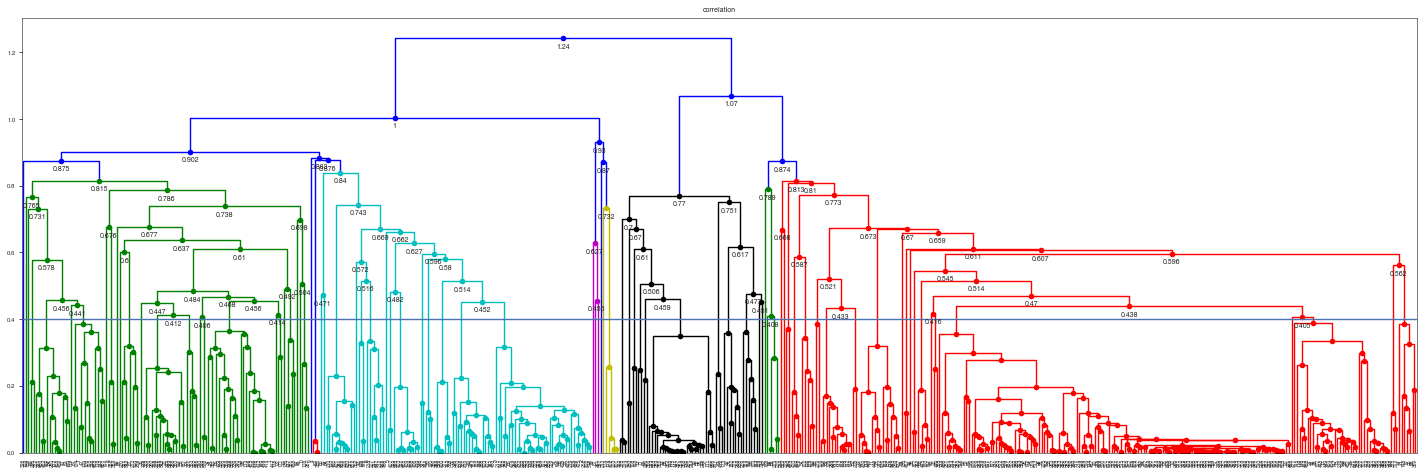

In [54]:
dists = plot_dendrogram(row_linkage, 0.4, "correlation")

In [55]:
clusters = hierarchy.fcluster(row_linkage, 0.1, criterion="distance")

In [56]:
print("n clusters: %s" % np.max(clusters))

n clusters: 223


In [57]:
cluster_map = pd.DataFrame.from_dict(dict(zip(list(corr.index), clusters)), orient="index")
cluster_map.columns = ["cluster"]
cluster_map.head()

,cluster
RUNX1,71
TFAP2A,55
Arnt,114
Ahr..Arnt,116
Ar,75


In [58]:
cluster_map.loc["KLF5"]

cluster    34
Name: KLF5, dtype: int64

## 3. plot clustered motif heatmap

In [59]:
colors = sns.husl_palette(np.max(clusters), s=0.75)
shuffle(colors)
lut = dict(zip(range(np.min(clusters), np.max(clusters)+1), colors))
row_colors = cluster_map["cluster"].map(lut)

In [60]:
cmap = sns.cubehelix_palette(8, start=.5, light=1, dark=0.25, hue=0.9, rot=-0.75, as_cmap=True)

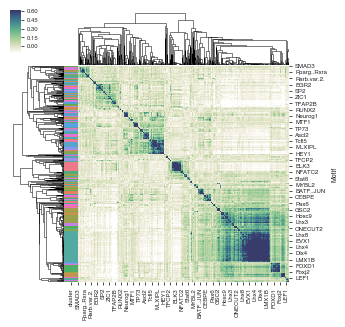

In [61]:
cg = sns.clustermap(corr, method="average", row_linkage=row_linkage, robust=True,
                    col_linkage=col_linkage, cmap=cmap, figsize=(5, 5), row_colors=row_colors,
                    linewidths=0, rasterized=True)
cg.savefig("Fig_S9A.pdf", bbox_inches="tight", dpi="figure")

In [62]:
cluster_map.to_csv("../../misc/02__mosbat/cluster_map.txt", sep="\t", index=True)

## 4. re-plot # bp covered and max coverage per biotype *after* clustering
note that i sent the cluster results to marta, who re-ran her coverage scripts using them, and i re-upload them in this notebook (so in real life there is a break between the above part and the following part of this notebook)

In [63]:
fimo_mosbat_cov.head()

,unique_id,cage_id,n_motifs,n_bp_cov,max_cov,log_n_motifs,log_bp_cov,log_max_cov,PromType2,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
0,protein_coding__p1@LOXL4__chr10:100027943..100...,"chr10:100027943..100027958,-",4,66,5,1.609438,4.204693,1.791759,protein_coding,5.375834,0.968756,0.666667,346.0,moderate
1,Enhancer__chr10:100074404-100074582,chr10:100074404-100074582,4,71,5,1.609438,4.276666,1.791759,Enhancer,0.015866,0.993289,0.666667,31.0,tissue-specific
2,Enhancer__chr10:100076038-100076149,chr10:100076038-100076149,2,74,11,1.098612,4.317488,2.484907,Enhancer,0.022990,0.995153,NaN,24.0,tissue-specific
3,Enhancer__chr10:100076500-100076699,chr10:100076500-100076699,4,87,8,1.609438,4.477337,2.197225,Enhancer,0.029745,0.981128,NaN,67.0,moderate
4,Enhancer__chr10:100082942-100083374,chr10:100082942-100083374,3,90,12,1.386294,4.510860,2.564949,Enhancer,0.023984,0.986789,0.666667,47.0,tissue-specific


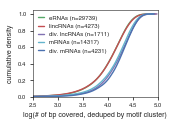

In [67]:
enh_vals = fimo_mosbat_cov[fimo_mosbat_cov["PromType2"] == "Enhancer"]["log_bp_cov"]
linc_vals = fimo_mosbat_cov[fimo_mosbat_cov["PromType2"] == "intergenic"]["log_bp_cov"]
dlnc_vals = fimo_mosbat_cov[fimo_mosbat_cov["PromType2"] == "div_lnc"]["log_bp_cov"]
pc_vals = fimo_mosbat_cov[fimo_mosbat_cov["PromType2"] == "protein_coding"]["log_bp_cov"]
dpc_vals = fimo_mosbat_cov[fimo_mosbat_cov["PromType2"] == "div_pc"]["log_bp_cov"]

fig = plt.figure(figsize=(2.25, 1.6))
ax = sns.kdeplot(data=enh_vals, cumulative=True, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs (n=%s)" % len(enh_vals))
sns.kdeplot(data=linc_vals, cumulative=True, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs (n=%s)" % len(linc_vals), ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs (n=%s)" % len(dlnc_vals), ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs (n=%s)" % len(pc_vals), ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs (n=%s)" % len(dpc_vals), ax=ax)
ax.set_xlabel("log(# of bp covered, deduped by motif cluster)")
ax.set_ylabel("cumulative density")
ax.set_ylim((0, 1.05))
ax.set_xlim((2.5, 5))
plt.legend(handlelength=1)
fig.savefig("Fig_S9B_1.pdf", bbox_inches="tight", dpi="figure")

i: 0, promtype: Enhancer, name: eRNAs
i: 1, promtype: intergenic, name: lincRNAs
i: 2, promtype: protein_coding, name: mRNAs


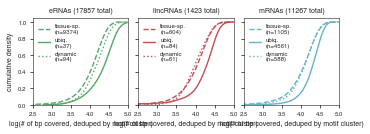

In [69]:
# for each group, split into tissue-sp v dynamic v ubiquitous
idxs = list(range(0, 5))
promtypes = ["Enhancer", "intergenic", "protein_coding"]
names = ["eRNAs", "lincRNAs", "mRNAs"]
df = mosbat_cov_exp
col = "log_bp_cov"
xlabel = "log(# of bp covered, deduped by motif cluster)"
xlim = (2.5, 5)

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(5.5, 1.6))

for i, promtype, name in zip(idxs, promtypes, names):
    print("i: %s, promtype: %s, name: %s" % (i, promtype, name))
    ax = axarr[i]
    
    promtype_vals = df[df["PromType2"] == promtype]
    ts_vals = promtype_vals[promtype_vals["tss_type"] == "tissue-specific"][col]
    ub_vals = promtype_vals[promtype_vals["tss_type"] == "ubiquitous"][col]
    dy_vals = promtype_vals[promtype_vals["tss_type"] == "dynamic"][col]
    
    sns.kdeplot(data=ts_vals, cumulative=True, color=TSS_CLASS_PALETTE[promtype], linestyle="dashed",
                label="tissue-sp.\n(n=%s)" % len(ts_vals), ax=ax)
    sns.kdeplot(data=ub_vals, cumulative=True, color=TSS_CLASS_PALETTE[promtype], linestyle="solid",
                label="ubiq.\n(n=%s)" % len(ub_vals), ax=ax)
    sns.kdeplot(data=dy_vals, cumulative=True, color=TSS_CLASS_PALETTE[promtype], linestyle="dotted",
                label="dynamic\n(n=%s)" % len(dy_vals), ax=ax)
    
    ax.set_title("%s (%s total)" % (name, len(promtype_vals)))
    ax.set_xlabel(xlabel)
    ax.legend(loc="bottom right", handlelength=2)
    ax.set_xlim(xlim)
    ax.set_ylim((0,1.05))
    
    if i == 0:
        ax.set_ylabel("cumulative density")
plt.subplots_adjust(wspace=0.1)

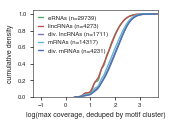

In [75]:
enh_vals = fimo_mosbat_cov[fimo_mosbat_cov["PromType2"] == "Enhancer"]["log_max_cov"]
linc_vals = fimo_mosbat_cov[fimo_mosbat_cov["PromType2"] == "intergenic"]["log_max_cov"]
dlnc_vals = fimo_mosbat_cov[fimo_mosbat_cov["PromType2"] == "div_lnc"]["log_max_cov"]
pc_vals = fimo_mosbat_cov[fimo_mosbat_cov["PromType2"] == "protein_coding"]["log_max_cov"]
dpc_vals = fimo_mosbat_cov[fimo_mosbat_cov["PromType2"] == "div_pc"]["log_max_cov"]

fig = plt.figure(figsize=(2.25, 1.6))
ax = sns.kdeplot(data=enh_vals, cumulative=True, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs (n=%s)" % len(enh_vals))
sns.kdeplot(data=linc_vals, cumulative=True, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs (n=%s)" % len(linc_vals), ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs (n=%s)" % len(dlnc_vals), ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs (n=%s)" % len(pc_vals), ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs (n=%s)" % len(dpc_vals), ax=ax)
ax.set_xlabel("log(max coverage, deduped by motif cluster)")
ax.set_ylabel("cumulative density")
plt.xlim((-1.35, 3.75))
plt.ylim((0,1.05))
plt.legend(handlelength=0.8)
fig.savefig("Fig_S9B_2.pdf", bbox_inches="tight", dpi="figure")

i: 0, promtype: Enhancer, name: eRNAs
i: 1, promtype: intergenic, name: lincRNAs
i: 2, promtype: protein_coding, name: mRNAs


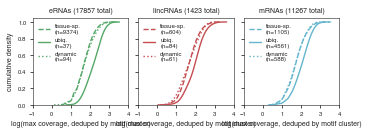

In [76]:
# for each group, split into tissue-sp v dynamic v ubiquitous
idxs = list(range(0, 5))
promtypes = ["Enhancer", "intergenic", "protein_coding"]
names = ["eRNAs", "lincRNAs", "mRNAs"]
df = mosbat_cov_exp
col = "log_max_cov"
xlabel = "log(max coverage, deduped by motif cluster)"
xlim = (-1, 4)

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(5.5, 1.6))

for i, promtype, name in zip(idxs, promtypes, names):
    print("i: %s, promtype: %s, name: %s" % (i, promtype, name))
    ax = axarr[i]
    
    promtype_vals = df[df["PromType2"] == promtype]
    ts_vals = promtype_vals[promtype_vals["tss_type"] == "tissue-specific"][col]
    ub_vals = promtype_vals[promtype_vals["tss_type"] == "ubiquitous"][col]
    dy_vals = promtype_vals[promtype_vals["tss_type"] == "dynamic"][col]
    
    sns.kdeplot(data=ts_vals, cumulative=True, color=TSS_CLASS_PALETTE[promtype], linestyle="dashed",
                label="tissue-sp.\n(n=%s)" % len(ts_vals), ax=ax)
    sns.kdeplot(data=ub_vals, cumulative=True, color=TSS_CLASS_PALETTE[promtype], linestyle="solid",
                label="ubiq.\n(n=%s)" % len(ub_vals), ax=ax)
    sns.kdeplot(data=dy_vals, cumulative=True, color=TSS_CLASS_PALETTE[promtype], linestyle="dotted",
                label="dynamic\n(n=%s)" % len(dy_vals), ax=ax)
    
    ax.set_title("%s (%s total)" % (name, len(promtype_vals)))
    ax.set_xlabel(xlabel)
    ax.legend(loc="bottom right", handlelength=2)
    ax.set_xlim(xlim)
    ax.set_ylim((0, 1.05))
    
    if i == 0:
        ax.set_ylabel("cumulative density")
plt.subplots_adjust(wspace=0.1)

## 5. look at conservation of nucleotides vs. motif coverage

### fimo only

In [77]:
res_dict = {}
df = fimo_phylop
nuc_cols = list(np.arange(-150, 150, step=1))

prev_max = 0
for max_motifs in [1, 10, 30, 86]:
    sub = df[(df["n_ov"] > prev_max) & (df["n_ov"] <= max_motifs)]
    n_motifs = len(sub)
    nums = np.asarray(sub[nuc_cols])
    
    avg = np.nanmean(nums, axis=0)
    std = np.nanstd(nums, axis=0)
    
    y1 = avg - std
    y2 = avg + std
    
    res_dict[max_motifs] = {"n_motifs": n_motifs, "avg": avg, "y1": y1, "y2": y2}
    prev_max = max_motifs

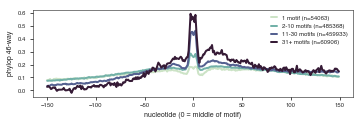

In [78]:
fig = plt.figure(figsize=(5.75,1.6))
palette = {1: sns.cubehelix_palette(4, start=.75, rot=-.75)[0], 10: sns.cubehelix_palette(4, start=.75, rot=-.75)[1], 
           30: sns.cubehelix_palette(4, start=.75, rot=-.75)[2], 86: sns.cubehelix_palette(4, start=.75, rot=-.75)[3]}
labels = ["1 motif", "2-10 motifs", "11-30 motifs", "31+ motifs"]

for n, label in zip(res_dict.keys(), labels):
    res = res_dict[n]
    n_motifs = res["n_motifs"]
    avg = res["avg"]
    y1 = res["y1"]
    y2 = res["y2"]
    # x = signal.savgol_filter(df["mean"], 15, 1)
    # plt.fill_between(nuc_cols, y1, y2, color=palette[n], alpha=0.5)
    plt.plot(nuc_cols, avg, color=palette[n], linewidth=2, label="%s (n=%s)" % (label, n_motifs))
# plt.xlim((lower, upper))
# plt.axvline(x=-75, color="black", linestyle="dashed", linewidth=1)
# plt.axvline(x=25, color="black", linestyle="dashed", linewidth=1)
plt.legend(ncol=1, loc=1, handlelength=1)
plt.xlabel("nucleotide (0 = middle of motif)")
plt.ylabel("phylop 46-way")

### fimo + chip

In [79]:
fimo_chip_phylop["n_ov"].max()

13

In [80]:
res_dict = {}
df = fimo_chip_phylop
nuc_cols = list(np.arange(-75, 75, step=1))

prev_max = 0
for max_motifs in [1, 4, 8, 13]:
    sub = df[(df["n_ov"] > prev_max) & (df["n_ov"] <= max_motifs)]
    n_motifs = len(sub)
    nums = np.asarray(sub[nuc_cols])
    
    avg = np.nanmean(nums, axis=0)
    std = np.nanstd(nums, axis=0)
    
    y1 = avg - std
    y2 = avg + std
    
    res_dict[max_motifs] = {"n_motifs": n_motifs, "avg": avg, "y1": y1, "y2": y2}
    prev_max = max_motifs

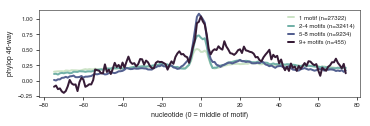

In [81]:
fig = plt.figure(figsize=(5.75,1.6))
palette = {1: sns.cubehelix_palette(4, start=.75, rot=-.75)[0], 4: sns.cubehelix_palette(4, start=.75, rot=-.75)[1], 
           8: sns.cubehelix_palette(4, start=.75, rot=-.75)[2], 13: sns.cubehelix_palette(4, start=.75, rot=-.75)[3]}
labels = ["1 motif", "2-4 motifs", "5-8 motifs", "9+ motifs"]

for n, label in zip(res_dict.keys(), labels):
    res = res_dict[n]
    n_motifs = res["n_motifs"]
    avg = res["avg"]
    y1 = res["y1"]
    y2 = res["y2"]
    # x = signal.savgol_filter(df["mean"], 15, 1)
    # plt.fill_between(nuc_cols, y1, y2, color=palette[n], alpha=0.5)
    plt.plot(nuc_cols, avg, color=palette[n], linewidth=2, label="%s (n=%s)" % (label, n_motifs))
# plt.xlim((lower, upper))
# plt.axvline(x=-75, color="black", linestyle="dashed", linewidth=1)
# plt.axvline(x=25, color="black", linestyle="dashed", linewidth=1)
plt.legend(ncol=1, loc=1, handlelength=1)
plt.xlabel("nucleotide (0 = middle of motif)")
plt.ylabel("phylop 46-way")
fig.savefig("Fig_2H.pdf", bbox_inches="tight", dpi="figure")

### clusters

In [82]:
fimo_clust_phylop["n_ov"].max()

13

In [83]:
res_dict = {}
df = fimo_clust_phylop
nuc_cols = list(np.arange(-75, 75, step=1))

prev_max = 0
for max_motifs in [1, 3, 6, 13]:
    sub = df[(df["n_ov"] > prev_max) & (df["n_ov"] <= max_motifs)]
    n_motifs = len(sub)
    nums = np.asarray(sub[nuc_cols])
    
    avg = np.nanmean(nums, axis=0)
    std = np.nanstd(nums, axis=0)
    
    y1 = avg - std
    y2 = avg + std
    
    res_dict[max_motifs] = {"n_motifs": n_motifs, "avg": avg, "y1": y1, "y2": y2}
    prev_max = max_motifs

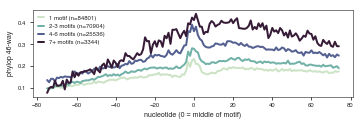

In [84]:
fig = plt.figure(figsize=(5.75,1.6))
palette = {1: sns.cubehelix_palette(4, start=.75, rot=-.75)[0], 3: sns.cubehelix_palette(4, start=.75, rot=-.75)[1], 
           6: sns.cubehelix_palette(4, start=.75, rot=-.75)[2], 13: sns.cubehelix_palette(4, start=.75, rot=-.75)[3]}
labels = ["1 motif", "2-3 motifs", "4-6 motifs", "7+ motifs"]

for n, label in zip(res_dict.keys(), labels):
    res = res_dict[n]
    n_motifs = res["n_motifs"]
    avg = res["avg"]
    y1 = res["y1"]
    y2 = res["y2"]
    # x = signal.savgol_filter(df["mean"], 15, 1)
    # plt.fill_between(nuc_cols, y1, y2, color=palette[n], alpha=0.5)
    plt.plot(nuc_cols, avg, color=palette[n], linewidth=2, label="%s (n=%s)" % (label, n_motifs))
# plt.xlim((lower, upper))
# plt.axvline(x=-75, color="black", linestyle="dashed", linewidth=1)
# plt.axvline(x=25, color="black", linestyle="dashed", linewidth=1)
plt.legend(ncol=1, loc=2, handlelength=1)
plt.xlabel("nucleotide (0 = middle of motif)")
plt.ylabel("phylop 46-way")

## 6. look at motif overlap vs. dnase accessibility

In [85]:
dnase_merged = dnase.merge(motif_cov_exp, on=["unique_id", "PromType2"])
dnase_merged["log_n_accessible"] = np.log10(dnase_merged["n_accessible"]+1)
dnase_merged.head()

,unique_id,n_accessible,PromType2,cage_id,n_motifs,n_bp_cov,max_cov,avg_tf_tissue_sp,log_n_motifs,log_bp_cov,log_max_cov,log_avg_tf_tissue_sp,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type,log_n_accessible
0,protein_coding__p1@LOXL4__chr10:100027943..100...,53,protein_coding,"chr10:100027943..100027958,-",19,66,7,NaN,2.995732,4.204693,2.079442,NaN,5.375834,0.968756,0.666667,346.0,moderate,1.732394
1,Enhancer__chr10:100074404-100074582,24,Enhancer,chr10:100074404-100074582,26,91,9,0.498479,3.295837,4.521789,2.302585,0.404451,0.015866,0.993289,0.666667,31.0,tissue-specific,1.397940
2,Enhancer__chr10:100076038-100076149,36,Enhancer,chr10:100076038-100076149,25,78,8,0.338257,3.258097,4.369448,2.197225,0.291368,0.022990,0.995153,NaN,24.0,tissue-specific,1.568202
3,Enhancer__chr10:100076500-100076699,36,Enhancer,chr10:100076500-100076699,21,89,8,0.394609,3.091042,4.499810,2.197225,0.332614,0.029745,0.981128,NaN,67.0,moderate,1.568202
4,Enhancer__chr10:100082942-100083374,42,Enhancer,chr10:100082942-100083374,36,93,13,0.375421,3.610918,4.543295,2.639057,0.318760,0.023984,0.986789,0.666667,47.0,tissue-specific,1.633468


r: 0.235685715297, spearman p: 0.0


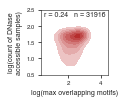

In [86]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(dnase_merged["log_max_cov"], dnase_merged["log_n_accessible"], 
                 cmap=sns.light_palette("firebrick", as_cmap=True), 
                 shade=True, shade_lowest=False, bw=0.13)
ax.set_ylabel("log(count of DNase\naccessible samples)")
ax.set_xlabel("log(max overlapping motifs)")
ax.set_ylim((0.5, 2.5))

r, p = stats.spearmanr(dnase_merged["log_max_cov"], dnase_merged["log_n_accessible"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(dnase_merged), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)
#fig.savefig("max_cov.v.dnase.pdf", bbox_inches="tight", dpi="figure")

r: 0.225433907744, spearman p: 0.0


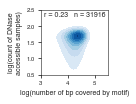

In [87]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(dnase_merged["log_bp_cov"], dnase_merged["log_n_accessible"], 
                 cmap="Blues", 
                 shade=True, shade_lowest=False, bw=0.13)
ax.set_ylabel("log(count of DNase\naccessible samples)")
ax.set_xlabel("log(number of bp covered by motif)")
ax.set_ylim((0.5, 2.5))
ax.set_xlim((3, 5.5))

r, p = stats.spearmanr(dnase_merged["log_bp_cov"], dnase_merged["log_n_accessible"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(dnase_merged), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)
#fig.savefig("bp_cov.v.dnase.pdf", bbox_inches="tight", dpi="figure")